In [1]:
import os
import random
import sys
import warnings
import numpy as np
import pandas as pd
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.utils import Progbar
from sklearn.model_selection import train_test_split

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.models import model_from_json

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

# Setting seed for reproducability
seed = 42
random.seed = seed
np.random.seed = seed
smooth = 1.
epochs = 50

Using TensorFlow backend.


In [2]:
# Data Path
TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

In [3]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [4]:
# Function read train images and mask return as nump array
def read_train_data(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    print('Getting and resizing train images and masks ... ')
    sys.stdout.flush()
    if os.path.isfile("train_img.npy") and os.path.isfile("train_mask.npy"):
        print("Train file loaded from memory")
        X_train = np.load("train_img.npy")
        Y_train = np.load("train_mask.npy")
        return X_train,Y_train
    a = Progbar(len(train_ids))
    for n, id_ in enumerate(train_ids):
        path = TRAIN_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[n] = img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                        preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
        Y_train[n] = mask
        a.update(n)
    np.save("train_img",X_train)
    np.save("train_mask",Y_train)
    return X_train,Y_train

In [5]:
# Function to read test images and return as numpy array
def read_test_data(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    sizes_test = []
    print('\nGetting and resizing test images ... ')
    sys.stdout.flush()
    if os.path.isfile("test_img.npy") and os.path.isfile("test_size.npy"):
        print("Test file loaded from memory")
        X_test = np.load("test_img.npy")
        sizes_test = np.load("test_size.npy")
        return X_test,sizes_test
    b = Progbar(len(test_ids))
    for n, id_ in enumerate(test_ids):
        path = TEST_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        sizes_test.append([img.shape[0], img.shape[1]])
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_test[n] = img
        b.update(n)
    np.save("test_img",X_test)
    np.save("test_size",sizes_test)
    return X_test,sizes_test

In [6]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [7]:
# Iterate over the test IDs and generate run-length encodings for each seperate mask identified by skimage
def mask_to_rle(preds_test_upsampled):
    new_test_ids = []
    rles = []
    for n, id_ in enumerate(test_ids):
        rle = list(prob_to_rles(preds_test_upsampled[n]))
        rles.extend(rle)
        new_test_ids.extend([id_] * len(rle))
    return new_test_ids,rles

In [8]:
# Metric function
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Loss funtion
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [9]:
def get_unet(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam',loss='binary_crossentropy', metrics=[dice_coef])
    return model

In [10]:
# get train_data
train_img,train_mask = read_train_data()

# get test_data
test_img,test_img_sizes = read_test_data()

Getting and resizing train images and masks ... 
Train file loaded from memory

Getting and resizing test images ... 
Test file loaded from memory


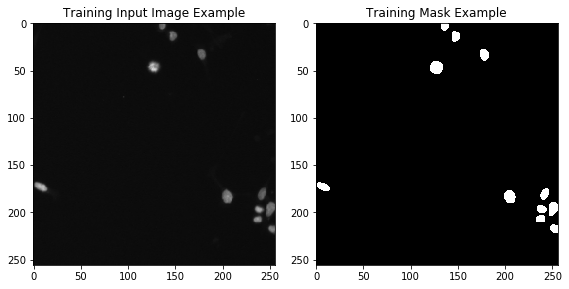

In [15]:
import matplotlib.pyplot as plt

indx = random.randint(0, len(train_img))
plt.figure(figsize=(8,8))
plt.subplot(121)
imshow(train_img[indx])
plt.title("Training Input Image Example")
plt.subplot(122)
imshow(np.squeeze(train_mask[indx]))
plt.title("Training Mask Example")
plt.show()

# Add cross validation

In [12]:
X_train, X_val, y_train , y_val = train_test_split(
    train_img,train_mask, test_size=0.2, random_state=seed)

In [13]:
print("X_train shape : {}".format(X_train.shape))
print("y_train shape : {}".format(y_train.shape))
print("X_val shape   : {}".format(X_val.shape))
print("y_val shape   : {}".format(y_val.shape))
print("X_test shape  : {}".format(test_img.shape))

X_train shape : (536, 256, 256, 3)
y_train shape : (536, 256, 256, 1)
X_val shape   : (134, 256, 256, 3)
y_val shape   : (134, 256, 256, 1)
X_test shape  : (65, 256, 256, 3)


In [14]:
# get u_net model
u_net = get_unet()

In [15]:
u_net.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 16) 0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [16]:
# fit model on train_data
from tensorflow.keras.callbacks import EarlyStopping
print("\nTraining...")
#epochs = 2
es = EarlyStopping(monitor='val_loss', mode='min', patience=3)
u_net.fit(X_train,y_train, validation_data=( X_val, y_val), batch_size=16,epochs=epochs, callbacks=[es])


Training...
Train on 536 samples, validate on 134 samples
Epoch 1/50
536/536 [==============================] - 237s 443ms/step - loss: 0.6307 - dice_coef: 0.2125 - val_loss: 0.4883 - val_dice_coef: 0.1756
Epoch 2/50
536/536 [==============================] - 176s 328ms/step - loss: 0.3808 - dice_coef: 0.2436 - val_loss: 0.2898 - val_dice_coef: 0.3044
Epoch 3/50
536/536 [==============================] - 175s 327ms/step - loss: 0.2606 - dice_coef: 0.4599 - val_loss: 0.2045 - val_dice_coef: 0.5141
Epoch 4/50
536/536 [==============================] - 175s 327ms/step - loss: 0.1780 - dice_coef: 0.6702 - val_loss: 0.1542 - val_dice_coef: 0.6767
Epoch 5/50
536/536 [==============================] - 175s 327ms/step - loss: 0.1477 - dice_coef: 0.7283 - val_loss: 0.1162 - val_dice_coef: 0.7523
Epoch 6/50
536/536 [==============================] - 174s 325ms/step - loss: 0.1221 - dice_coef: 0.7776 - val_loss: 0.0980 - val_dice_coef: 0.7912
Epoch 7/50
536/536 [==============================] -

In [29]:
# serialize model to JSON
model_json = u_net.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
u_net.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [17]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [18]:
print("Predicting")
# Predict on test data
test_mask = loaded_model.predict(test_img,verbose=1)

Predicting
65/65 [==============================] - 9s 143ms/step


In [36]:
print("Predicting")
# Predict on test data
#test_mask = u_net.predict(test_img,verbose=1)

Predicting


In [19]:
# Create list of upsampled test masks
test_mask_upsampled = []
for i in range(len(test_mask)):
    test_mask_upsampled.append(resize(np.squeeze(test_mask[i]),
                                       (test_img_sizes[i][0],test_img_sizes[i][1]), 
                                       mode='constant', preserve_range=True))


In [20]:
test_ids,rles = mask_to_rle(test_mask_upsampled)

In [21]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))

#sub.to_csv('sub-dsbowl2018.csv', index=False)

In [22]:
sub

,ImageId,EncodedPixels
0,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,44848 9 45102 12 45357 14 45612 15 45868 15 46...
1,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,49770 4 50023 9 50277 12 50531 15 50786 16 510...
2,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,10637 4 10891 8 11145 10 11399 13 11655 13 119...
3,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,31374 9 31628 13 31882 16 32137 17 32392 19 32...
4,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,50586 4 50840 7 51094 10 51349 11 51603 13 518...
...,...,...
2198,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,239 11 494 11 752 9
2199,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,63738 4 63992 8 64246 11 64501 12 64756 13 650...
2200,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,47103 2 47358 3 47614 3 47870 3 48126 3 48383 ...
2201,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,17663 1 17919 1 18175 2 18431 2 18686 3 18942 ...


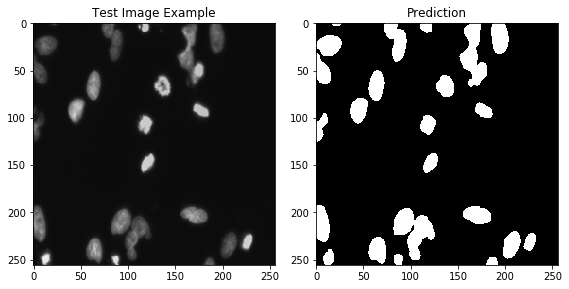

In [57]:
indx = random.randint(0, len(test_img))
plt.figure(figsize=(8,8))
plt.subplot(121)
imshow(test_img[indx])
plt.title("Test Image Example")
plt.subplot(122)
imshow(np.squeeze(test_mask[indx] > 0.5))
plt.title("Prediction")
plt.show()